# Bayesian imaging for DSHARP protoplanetary disks.

We introduce in this notebook how to perform inference with IRIS. This tutorial can either be started using the final file from the previous tutorial, or by using one of the Zenodo dataset as a starting point. We will continue our analysis of the disk RU Lup. The same approach can be applied for other protoplanetary disks. 

*Important:* We recommend running this notebook on a computer supporting the cuda version of torch. This will make the inference procedure much faster. 

We will first import the observation (sampled visibilities), the noise estimate and the forward model parameters to plot the dirty image.  

In [1]:
import h5py
import os 
import sys
sys.path.append("../src")
import numpy as np
import torch 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

device = "cuda" if torch.cuda.is_available() else "cpu"

If you did the first tutorial, you can start by running this cell.

In [2]:
data_folder = "data"
fname = os.path.join(data_folder, "RULup_continuum_preprocessed.h5")
with h5py.File(fname, "r") as hdf:
    vis = torch.tensor(hdf["vis"][:], device = device, dtype = torch.float32) # Jy
    vis_noise = torch.tensor(hdf["vis_noise"][:], device = device, dtype = torch.float32) # Jy (standard deviation of a Gaussian)
    S = torch.tensor(hdf["sampling_function"][:], dtype = torch.bool, device = device)
    mean_freq = hdf["freq"][()] # Hz
    B = hdf["B"][()]
    pad = tuple(hdf["pad"][:])
npix = S.shape[0]
img_size = 256
disk = "RULup_continuum"


If you didn't do the first tutorial, you can start by running the following cell. 

In [2]:
import wget
import os 

disk = "RULup_continuum" # you can change for another disk in the DSHARP survey !

data_folder = "data" # or wherever you want
os.makedirs(data_folder, exist_ok=True)
fname = os.path.join(data_folder, f"{disk}_ve_probes_euler.h5")
url = f"https://zenodo.org/api/records/14345309/draft/files/{disk}_veprobes_euler.h5/content"
wget.download(url, fname)


HTTPError: HTTP Error 403: FORBIDDEN

We can plot our observation (i.e. the gridded visibilities), from which we want to infer surface brightness of protoplanetary disks. 

Text(0.5, 1.0, 'Visibility amplitude $|\\mathcal{V}|$')

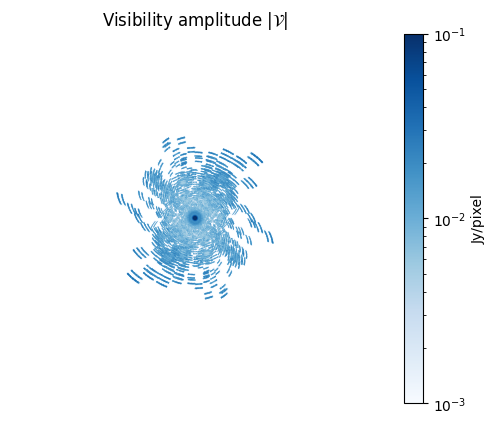

In [5]:
vis_grid = torch.empty(size = (npix, npix), dtype = torch.complex64, device = device)

m = len(vis) // 2 # number of measured visibilities (no vectorized representation)
vis_grid[S] = vis[:m] + 1j * vis[m:]

norm = LogNorm(vmin = 1e-3, vmax = 1e-1)
im = plt.imshow(torch.abs(vis_grid).cpu(), cmap = "Blues", norm = norm)
plt.axis("off")
cbar = plt.colorbar(im, fraction = 0.0455)
cbar.set_label("Jy/pixel")
plt.title(r"Visibility amplitude $|\mathcal{V}|$")

We can also define the different parameters of our forward model in a tuple.

In [6]:
from inference.forward_model import gaussian_pb
model_params = (S, torch.ones(size = (npix, npix), device = device), B, 0, pad, "zero")

# Computing the primary beam. 
import json

with open("../dsharp_params.json", 'r') as file:
    dict_disks_info = json.load(file) 

disk_info = dict_disks_info[disk]
pixel_scale = disk_info['pixel_scale'] # pixel size in image space (arcsec)
pb, _ = gaussian_pb(diameter = 12, freq = mean_freq, shape = (img_size, img_size), pixel_scale = pixel_scale, device = device)


## Loading the Score Model

The neural network in our approach is a score-based model (from this [paper](https://arxiv.org/abs/2011.13456)). We use the implementation in the `score_models` package (you can find more information on this package [here](https://github.com/AlexandreAdam/score_models)). 

In [7]:
# Add piece of code to download the score model from zenodo and unzip it. 

In [8]:
from score_models import ScoreModel
score_model = ScoreModel(checkpoints_directory="data/score_ve_probes_256")

c:\Users\noedi\Desktop\Ciela\Projects\bayesian_imaging_radio\code\public_code\.venv\lib\site-packages\score_models\utils.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

Using the Variance Exploding SDE


## Inference 
We now have all the elements in place to perform the inference. Posterior samples can be created using the `euler_sampler` function as follows  

In [37]:
from inference.posterior_sampling import score_likelihood, euler_sampler
from inference.forward_model import model

# Running this takes ~ 1 hour on CPU, but ~6 min on a NVIDIA RTX 3050Ti GPU. 
samples = euler_sampler(
            y = vis,
            sigma_y = vis_noise, 
            forward_model = model, 
            score_model = score_model,
            score_likelihood =  score_likelihood, 
            model_parameters = model_params,
            num_samples = 1,
            num_steps = 1000,  
            img_size = (img_size, img_size)
        ) # dividing by primary beam after inference 

t = 0.00 | scale ~ 6.47e-01 | sigma(t) = 1.03e-04 | mu(t) = 1.00e+00: 100%|██████████| 999/999 [06:34<00:00,  2.53it/s]


We now analyze the posterior sample by computing the residuals that it yields, and plotting everything

In [55]:
vis_pred = model(None, samples, None, model_params)
image = B * samples / pb / pixel_scale ** 2 # Posterior samples in Jy/arcsec^2

residuals = (vis - vis_pred) / vis_noise
residuals_grid = torch.empty(size = (npix, npix), dtype = torch.complex64, device = device)

residuals_grid[S] = residuals[:m] + 1j * residuals[m:]
reduced_chi2_real = torch.sum(residuals_grid.real ** 2)/ m
reduced_chi2_imag = torch.sum(residuals_grid.imag ** 2)/ m

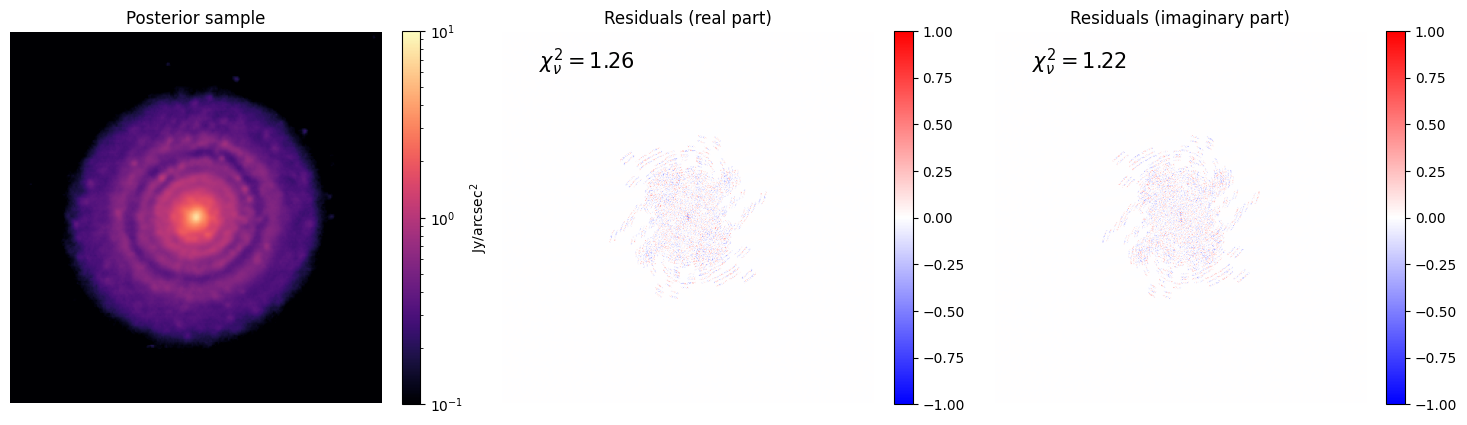

In [57]:
fig, axs = plt.subplots(1, 3, figsize = (6 * 3, 6))
for ax in axs: 
    ax.axis("off")

norm = LogNorm(vmin = 1e-1, vmax = 1e1, clip = True)
im = axs[0].imshow(image.squeeze().cpu(), cmap = "magma", origin = "lower", norm = norm)
axs[0].set_title("Posterior sample")
cbar = plt.colorbar(im, fraction = 0.0455)
cbar.set_label(r"Jy/arcsec$^2$")

im = axs[1].imshow(residuals_grid.real.squeeze().cpu(), cmap = "bwr", origin = "lower", vmin=-1, vmax = 1)
axs[1].set_title("Residuals (real part)")
axs[1].annotate(r"$\chi^2_\nu=$%.2f"%reduced_chi2_real, (0.1, 0.9), xycoords = "axes fraction", fontsize = 15)
cbar = plt.colorbar(im, fraction = 0.0455)


im = axs[2].imshow(residuals_grid.imag.squeeze().cpu(), cmap = "bwr", origin = "lower", vmin=-1, vmax = 1)
axs[2].set_title("Residuals (imaginary part)")
axs[2].annotate(r"$\chi^2_\nu=$%.2f"%reduced_chi2_imag, (0.1, 0.9), xycoords = "axes fraction", fontsize = 15)
cbar = plt.colorbar(im, fraction = 0.0455)

We can finally do here a small sanity check by computing the flux obtained with the posterior sample. In the original DSHARP paper, the flux obtained for RU Lup is $\sim 203$ mJy (see Table 4 of the [first DSHARP paper](https://arxiv.org/abs/1812.04040)).

In [61]:
flux = (image * pixel_scale ** 2).sum() * 1e3 
print(flux.item())

203.13430786132812
